In [3]:
import torch
from torch import Tensor
from torch.nn import Linear, ReLU, Sequential
import torch.nn.functional as F
from torch_geometric.data import HeteroData
from torch_geometric.loader import LinkNeighborLoader
from torch_geometric.nn import HeteroConv, GATConv, SAGEConv, Linear
from torch_geometric.nn.aggr import Aggregation, MultiAggregation
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.typing import OptPairTensor, Adj, Size
import os.path as path
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import tqdm
from typing import Optional, Union, List, Tuple
import matplotlib.pyplot as plt
import copy

In [ ]:
data_folder = "ds/"
model_name = "main"
year = 2019
month = 11
perc = 0
train_hd = f"train_hd_{year}_{month}_{perc}.pt"
# train_hd = f"train_hd_nomatch_{year}_{month}_{perc}.pt"

In [5]:
results_df = pd.read_csv("results.csv", dtype={
    "model": str,
    "year": int,
    "month": int,
    "perc": float,
    "epoch": int,
    "train_loss": float,
    "val_loss": float,
    "acc": float,
    "prec": float,
    "rec": float,
    "f1": float,
    "auc": float,
    "tp": int,
    "fp": int,
    "fn": int,
    "tn": int,
    "best_threshold": float,
    "done": bool
})

filtered_df = results_df[
    (results_df["model"] == model_name) &
    (results_df["year"] == year) &
    (results_df["month"] == month) &
    (results_df["perc"] == perc)
]

if filtered_df.empty:
    latest_epoch = 0
    is_trained = False
else:
    latest_epoch = filtered_df["epoch"].max()
    is_trained = filtered_df["done"].any()

print("Latest epoch:", latest_epoch)
print("Is trained?", is_trained)

Latest epoch: 35
Is trained? False


In [6]:
data = torch.load(path.join(data_folder, train_hd))

data.validate()

/tmp/ipykernel_31800/2815972150.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(path.join(data_folder, train_hd))


True

In [7]:
artist_channels = data["artist"].x.size(1)
track_channels = data["track"].x.size(1)
tag_channels = data["tag"].x.size(1)

print(f"Artist channels: {artist_channels}")
print(f"Track channels: {track_channels}")
print(f"Tag channels: {tag_channels}")

Artist channels: 16
Track channels: 5
Tag channels: 24


In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

data["artist", "collab_with", "artist"].edge_index = data["artist", "collab_with", "artist"].edge_index.contiguous()

print(f"Device: '{device}'")

Device: 'cuda'


In [9]:
compt_tree_size = [25, 20]

print("Creating train_loader...")
train_loader = LinkNeighborLoader(
    data=data,
    num_neighbors=compt_tree_size,
    neg_sampling_ratio=1,
    edge_label_index=("artist", "collab_with", "artist"),
    batch_size=128,
    shuffle=True,
    num_workers=10,
    pin_memory=True,
)

Creating train_loader...


/home/aleferu/miniforge3/envs/musicbrainz/lib/python3.12/site-packages/torch_geometric/sampler/neighbor_sampler.py:61: UserWarning: Using 'NeighborSampler' without a 'pyg-lib' installation is deprecated and will be removed soon. Please install 'pyg-lib' for accelerated neighborhood sampling
  warnings.warn(f"Using '{self.__class__.__name__}' without a "


In [10]:
train_count = int(0.8 * len(train_loader))
val_count = len(train_loader) - train_count

print(train_count)
print(val_count)

11033
2759


In [11]:
class MLPSAGEConv(MessagePassing):
    r"""The GraphSAGE operator with an MLP instead of the linear transformation.

    Args:
        in_channels (int or tuple): Size of each input sample, or :obj:`-1` to
            derive the size from the first input(s) to the forward method.
            A tuple corresponds to the sizes of source and target
            dimensionalities.
        out_channels (int): Size of each output sample.
        hidden_channels (int, optional): Size of the hidden layer in the MLP.
            (default: :obj:`64`)
        aggr (str or Aggregation, optional): The aggregation scheme to use.
            Any aggregation of :obj:`torch_geometric.nn.aggr` can be used,
            *e.g.*, :obj:`"mean"`, :obj:`"max"`, or :obj:`"lstm"`.
            (default: :obj:`"mean"`)
        normalize (bool, optional): If set to :obj:`True`, output features
            will be :math:`\ell_2`-normalized, *i.e.*,
            :math:`\frac{\mathbf{x}^{\prime}_i}
            {\| \mathbf{x}^{\prime}_i \|_2}`.
            (default: :obj:`False`)
        root_weight (bool, optional): If set to :obj:`False`, the layer will
            not add transformed root node features to the output.
            (default: :obj:`True`)
        bias (bool, optional): If set to :obj:`False`, the layer will not learn
            an additive bias. (default: :obj:`True`)
        **kwargs (optional): Additional arguments of
            :class:`torch_geometric.nn.conv.MessagePassing`.

    Shapes:
        - **inputs:**
          node features :math:`(|\mathcal{V}|, F_{in})` or
          :math:`((|\mathcal{V_s}|, F_{s}), (|\mathcal{V_t}|, F_{t}))`
          if bipartite,
          edge indices :math:`(2, |\mathcal{E}|)`
        - **outputs:** node features :math:`(|\mathcal{V}|, F_{out})` or
          :math:`(|\mathcal{V_t}|, F_{out})` if bipartite
    """

    def __init__(
        self,
        in_channels: Union[int, Tuple[int, int]],
        out_channels: int,
        hidden_channels: int = 64,
        aggr: Optional[Union[str, List[str], Aggregation]] = "mean",
        normalize: bool = False,
        root_weight: bool = True,
        bias: bool = True,
        **kwargs,
    ):
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.hidden_channels = hidden_channels
        self.normalize = normalize
        self.root_weight = root_weight

        if isinstance(in_channels, int):
            in_channels = (in_channels, in_channels)

        if aggr == "lstm":
            kwargs.setdefault("aggr_kwargs", {})
            kwargs["aggr_kwargs"].setdefault("in_channels", in_channels[0])
            kwargs["aggr_kwargs"].setdefault("out_channels", in_channels[0])

        super().__init__(aggr, **kwargs)


        self.mlp = Sequential(
            Linear(in_channels[0], hidden_channels),
            ReLU(),
            Linear(hidden_channels, in_channels[0]) # Output size should match input for aggregation
        )

        if isinstance(self.aggr_module, MultiAggregation):
            aggr_out_channels = self.aggr_module.get_out_channels(in_channels[0])
        else:
            aggr_out_channels = in_channels[0]

        self.lin_l = Linear(aggr_out_channels, out_channels, bias=bias)
        if self.root_weight:
            self.lin_r = Linear(in_channels[1], out_channels, bias=False)

        self.reset_parameters()

    def reset_parameters(self):
        super().reset_parameters()
        for layer in self.mlp:
            if hasattr(layer, 'reset_parameters'):
                layer.reset_parameters()
        self.lin_l.reset_parameters()
        if self.root_weight:
            self.lin_r.reset_parameters()

    def forward(
        self,
        x: Union[Tensor, OptPairTensor],
        edge_index: Adj,
        size: Size = None,
    ) -> Tensor:

        if isinstance(x, Tensor):
            x = (x, x)

        # Propagate through MLP
        x = (self.mlp(x[0]), x[1])

        # propagate_type: (x: OptPairTensor)
        out = self.propagate(edge_index, x=x, size=size)
        out = self.lin_l(out)

        x_r = x[1]
        if self.root_weight and x_r is not None:
            out = out + self.lin_r(x_r)

        if self.normalize:
            out = F.normalize(out, p=2.0, dim=-1)

        return out

    def message(self, x_j: Tensor) -> Tensor:
        return x_j

    def message_and_aggregate(self, adj_t: Adj, x: OptPairTensor) -> Tensor:
        if isinstance(adj_t, SparseTensor):
            adj_t = adj_t.set_value(None, layout=None)
        return spmm(adj_t, x[0], reduce=self.aggr)

    def __repr__(self) -> str:
        return (
            f"{self.__class__.__name__}({self.in_channels}, "
            f"{self.out_channels}, hidden_channels={self.hidden_channels}, aggr={self.aggr})"
        )



In [12]:
class GNN(torch.nn.Module):
    def __init__(self, metadata, hidden_channels, out_channels):
        super().__init__()
        self.metadata = metadata
        self.out_channels = out_channels

        self.conv1 = HeteroConv({
            ("artist", "collab_with", "artist"): GATConv((artist_channels, artist_channels), hidden_channels),
            ("artist", "has_tag_artists", "tag"): SAGEConv((artist_channels, tag_channels), hidden_channels),
            # ("artist", "last_fm_match", "artist"): GATConv((artist_channels, artist_channels), hidden_channels),
            ("track", "has_tag_tracks", "tag"): SAGEConv((track_channels, tag_channels), hidden_channels),
            ("artist", "linked_to", "artist"): GATConv((artist_channels, artist_channels), hidden_channels),
            ("artist", "musically_related_to", "artist"): GATConv((artist_channels, artist_channels), hidden_channels),
            ("artist", "personally_related_to", "artist"): GATConv((artist_channels, artist_channels), hidden_channels),
            ("tag", "tags_artists", "artist"): SAGEConv((tag_channels, artist_channels), hidden_channels),
            ("tag", "tags_tracks", "track"): SAGEConv((tag_channels, track_channels), hidden_channels),
            ("track", "worked_by", "artist"): SAGEConv((track_channels, artist_channels), hidden_channels),
            ("artist", "worked_in", "track"): SAGEConv((artist_channels, track_channels), hidden_channels),
        }, aggr="mean")

        self.conv2 = HeteroConv({
            ("artist", "collab_with", "artist"): GATConv((hidden_channels, hidden_channels), hidden_channels),
            ("artist", "has_tag_artists", "tag"): SAGEConv((hidden_channels, hidden_channels), hidden_channels),
            # ("artist", "last_fm_match", "artist"): GATConv((hidden_channels, hidden_channels), hidden_channels),
            ("track", "has_tag_tracks", "tag"): SAGEConv((hidden_channels, hidden_channels), hidden_channels),
            ("artist", "linked_to", "artist"): GATConv((hidden_channels, hidden_channels), hidden_channels),
            ("artist", "musically_related_to", "artist"): GATConv((hidden_channels, hidden_channels), hidden_channels),
            ("artist", "personally_related_to", "artist"): GATConv((hidden_channels, hidden_channels), hidden_channels),
            ("tag", "tags_artists", "artist"): SAGEConv((hidden_channels, hidden_channels), hidden_channels),
            ("tag", "tags_tracks", "track"): SAGEConv((hidden_channels, hidden_channels), hidden_channels),
            ("track", "worked_by", "artist"): SAGEConv((hidden_channels, hidden_channels), hidden_channels),
            ("artist", "worked_in", "track"): SAGEConv((hidden_channels, hidden_channels), hidden_channels),
        }, aggr="mean")

        self.linear1 = Linear(hidden_channels * 2, hidden_channels * 4)
        self.linear2 = Linear(hidden_channels * 4, out_channels)

    def forward(self, x_dict, edge_index_dict):
        x_dict1 = self.conv1(x_dict, edge_index_dict)
        x_dict2 = self.conv2(x_dict1, edge_index_dict)

        x_artist = torch.cat([x_dict1['artist'], x_dict2['artist']], dim=-1)

        x_artist = self.linear1(x_artist)
        x_artist = self.linear2(x_artist)

        # Normalize the artist node features
        x_artist = F.normalize(x_artist, p=2, dim=-1)

        # Update the dictionary with the new 'artist' features, leaving other nodes unchanged
        x_dict['artist'] = x_artist

        return x_dict

In [13]:
def train(model, train_loader, optimizer, criterion, device, num_epochs, results_df, patience=5):
    best_val_f1 = 0.0
    best_threshold = 0
    epochs_no_improve = 0
    best_model_state = None
    train_losses = list()
    val_losses = list()
    best_epoch = 0

    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        epoch_loss = 0.0
        train_loader_iter = iter(train_loader)
        
        for i in tqdm.tqdm(range(train_count)):
            # Move data to device
            sampled_data = next(train_loader_iter).to(device)
            
            # Forward pass
            pred_dict = model(sampled_data.x_dict, sampled_data.edge_index_dict)
            
            # Get predictions and labels for the 'collab_with' edge type
            edge_label_index = sampled_data['artist', 'collab_with', 'artist'].edge_label_index
            edge_label = sampled_data['artist', 'collab_with', 'artist'].edge_label

            src_emb = pred_dict['artist'][edge_label_index[0]]  # Source node embeddings
            dst_emb = pred_dict['artist'][edge_label_index[1]]  # Destination node embeddings
            
            # Compute the dot product between source and destination embeddings
            preds = (src_emb * dst_emb).sum(dim=-1)  # Scalar for each edge
            
            # Compute loss
            loss = criterion(preds, edge_label.float())
            epoch_loss += loss.item()
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        # Average loss for the epoch
        epoch_loss /= train_count
        train_losses.append(epoch_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}")

        print("Computing validation metrics")
        
        # Validation metrics
        model.eval()  # Set model to evaluation mode
        all_labels = []
        all_probs = []
        val_loss = 0.0
        
        with torch.no_grad():  # Disable gradient computation for validation
            for i in tqdm.tqdm(range(val_count)):
                # Move data to device
                sampled_data = next(train_loader_iter).to(device)
                
                # Forward pass
                pred_dict = model(sampled_data.x_dict, sampled_data.edge_index_dict)
                
                # Get predictions and labels for the 'collab_with' edge type
                edge_label_index = sampled_data['artist', 'collab_with', 'artist'].edge_label_index
                edge_label = sampled_data['artist', 'collab_with', 'artist'].edge_label

                src_emb = pred_dict['artist'][edge_label_index[0]]  # Source node embeddings
                dst_emb = pred_dict['artist'][edge_label_index[1]]  # Destination node embeddings
                
                # Compute the dot product between source and destination embeddings
                preds = (src_emb * dst_emb).sum(dim=-1)  # Scalar for each edge

                loss = criterion(preds, edge_label.float())
                val_loss += loss.item()

                probs = torch.sigmoid(preds)  # Convert to probabilities
                
                # Collect predictions, probabilities, and labels
                all_labels.append(edge_label.cpu())
                all_probs.append(probs.cpu())
        
        # Concatenate all predictions and labels
        all_labels = torch.cat(all_labels)
        all_probs = torch.cat(all_probs)

        val_loss /= val_count
        val_losses.append(val_loss)

        # Find threshold for predictions
        print("Looking for threshold")
        best_threshold_epoch = 0
        best_f1_epoch = 0
        for threshold in tqdm.tqdm(np.arange(0.2, 0.91, 0.01)):
            preds_binary = (all_probs > threshold).long()
            cm = confusion_matrix(all_labels, preds_binary)
            tp = cm[1, 1]
            fp = cm[0, 1]
            fn = cm[1, 0]
            tn = cm[0, 0]
            precision = 0 if tp == 0 else tp / (tp + fp)
            recall = 0 if tp == 0 else tp / (tp + fn)
            f1 = 0 if precision * recall == 0 else 2 * precision * recall / (precision + recall)
            if f1 > best_f1_epoch:
                best_threshold_epoch = threshold
                best_f1_epoch = f1
        print(f"Best threshold: {best_threshold_epoch}")
        all_preds = (all_probs > best_threshold_epoch).long()
        
        # Compute metrics
        cm = confusion_matrix(all_labels, all_preds)
        tp = cm[1, 1]
        fp = cm[0, 1]
        fn = cm[1, 0]
        tn = cm[0, 0]
        accuracy = (tp + tn) / (tp + fp + fn + tn)
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        f1 = 2 * precision * recall / (precision + recall)
        roc_auc = roc_auc_score(all_labels, all_probs)
        
        # Print validation metrics
        print(f"Validation Metrics - Epoch {epoch+1}/{num_epochs}:")
        print(f"Loss:      {val_loss:.4f}")
        print(f"Accuracy:  {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall:    {recall:.4f}")
        print(f"F1-score:  {f1:.4f}")
        print(f"ROC-AUC:   {roc_auc:.4f}")
        print(f"Confusion Matrix:\n{tp} {fn}\n{fp} {tn}")

        new_row = pd.DataFrame(
            {
                "model": [model_name],
                "year": [year],
                "month": [month],
                "perc": [perc],
                "epoch": [latest_epoch + epoch + 1],
                "train_loss": [epoch_loss],
                "val_loss": [val_loss],
                "acc": [accuracy],
                "prec": [precision],
                "rec": [recall],
                "f1": [f1],
                "auc": [roc_auc],
                "tp": [tp],
                "fp": [fp],
                "fn": [fn],
                "tn": [tn],
                "best_threshold": [best_threshold_epoch],
                "done": [False]
            }
        )
        results_df = pd.concat([results_df, new_row], ignore_index=True)
        results_df.to_csv("results.csv", index=False)

        torch.save(model.state_dict(), f"./model_{model_name}_{year}_{month}_{perc}_{latest_epoch + epoch + 1}.pth")

        if f1 > best_val_f1:
            best_val_f1 = f1
            best_threshold = best_threshold_epoch
            epochs_no_improve = 0
            best_model_state = copy.deepcopy(model.state_dict())
            best_epoch = latest_epoch + epoch + 1
        else:
            epochs_no_improve += 1
            if epochs_no_improve == patience:
                print(f"Early stopping!!!")
                print(f"Early stopping!!!")
                print(f"Early stopping!!!")
                print("Best epoch:", best_epoch)
                model.load_state_dict(best_model_state)
                break

    return best_threshold, train_losses, val_losses


In [14]:
model = GNN(metadata=data.metadata(), hidden_channels=64, out_channels=64).to(device)

model.load_state_dict(
    torch.load("model_main_nomatch_2019_11_0_35.pth")
)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

best_threshold, train_losses, val_losses = train(
    model,
    train_loader,
    optimizer,
    F.binary_cross_entropy_with_logits,
    device,
    100,
    results_df
)


/tmp/ipykernel_31800/3664580216.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load("model_main_nomatch_2019_11_0_35.pth")
100%|██████████| 11033/11033 [05:50<00:

Epoch 1/100, Training Loss: 0.5253
Computing validation metrics


100%|██████████| 2759/2759 [01:09<00:00, 39.59it/s]


Looking for threshold


100%|██████████| 71/71 [01:35<00:00,  1.35s/it]


Best threshold: 0.6900000000000004
Validation Metrics - Epoch 1/100:
Loss:      0.5264
Accuracy:  0.9202
Precision: 0.8913
Recall:    0.9571
F1-score:  0.9230
ROC-AUC:   0.9578
Confusion Matrix:
337931 15147
41212 311866


100%|██████████| 11033/11033 [05:42<00:00, 32.22it/s]


Epoch 2/100, Training Loss: 0.5253
Computing validation metrics


100%|██████████| 2759/2759 [01:09<00:00, 39.66it/s]


Looking for threshold


100%|██████████| 71/71 [01:36<00:00,  1.36s/it]


Best threshold: 0.6900000000000004
Validation Metrics - Epoch 2/100:
Loss:      0.5246
Accuracy:  0.9145
Precision: 0.8899
Recall:    0.9461
F1-score:  0.9171
ROC-AUC:   0.9556
Confusion Matrix:
334060 19018
41347 311731


100%|██████████| 11033/11033 [05:50<00:00, 31.51it/s]


Epoch 3/100, Training Loss: 0.5252
Computing validation metrics


100%|██████████| 2759/2759 [01:07<00:00, 41.01it/s]


Looking for threshold


100%|██████████| 71/71 [01:33<00:00,  1.32s/it]


Best threshold: 0.6800000000000004
Validation Metrics - Epoch 3/100:
Loss:      0.5253
Accuracy:  0.9127
Precision: 0.8848
Recall:    0.9489
F1-score:  0.9157
ROC-AUC:   0.9532
Confusion Matrix:
335039 18039
43630 309448


100%|██████████| 11033/11033 [05:33<00:00, 33.09it/s]


Epoch 4/100, Training Loss: 0.5252
Computing validation metrics


100%|██████████| 2759/2759 [01:11<00:00, 38.83it/s]


Looking for threshold


100%|██████████| 71/71 [01:34<00:00,  1.33s/it]


Best threshold: 0.6800000000000004
Validation Metrics - Epoch 4/100:
Loss:      0.5255
Accuracy:  0.9111
Precision: 0.8875
Recall:    0.9416
F1-score:  0.9137
ROC-AUC:   0.9527
Confusion Matrix:
332447 20631
42133 310945


100%|██████████| 11033/11033 [05:35<00:00, 32.87it/s]


Epoch 5/100, Training Loss: 0.5249
Computing validation metrics


100%|██████████| 2759/2759 [01:02<00:00, 44.01it/s]


Looking for threshold


100%|██████████| 71/71 [01:35<00:00,  1.34s/it]


Best threshold: 0.6700000000000004
Validation Metrics - Epoch 5/100:
Loss:      0.5257
Accuracy:  0.9106
Precision: 0.8791
Recall:    0.9521
F1-score:  0.9141
ROC-AUC:   0.9529
Confusion Matrix:
336181 16897
46254 306824


100%|██████████| 11033/11033 [05:43<00:00, 32.08it/s]


Epoch 6/100, Training Loss: 0.5250
Computing validation metrics


100%|██████████| 2759/2759 [01:01<00:00, 44.79it/s]


Looking for threshold


100%|██████████| 71/71 [01:33<00:00,  1.32s/it]


Best threshold: 0.6700000000000004
Validation Metrics - Epoch 6/100:
Loss:      0.5238
Accuracy:  0.9110
Precision: 0.8780
Recall:    0.9547
F1-score:  0.9147
ROC-AUC:   0.9553
Confusion Matrix:
337078 16000
46839 306239
Early stopping!!!
Early stopping!!!
Early stopping!!!
Best epoch: 36


In [15]:
print("BEST THRESHOLD:", best_threshold)

BEST THRESHOLD: 0.6900000000000004


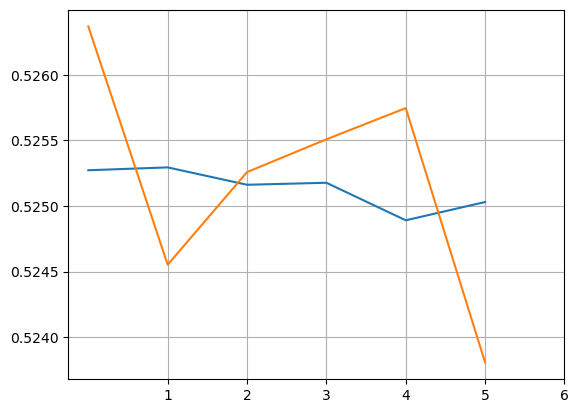

In [16]:
plt.plot(train_losses, label="Training loss")
plt.plot(val_losses, label="Validation loss")

plt.xticks(range(1, len(train_losses) + 1))
plt.grid(True)

plt.show()

In [17]:
torch.save(model.state_dict(), f"./model_{model_name}_{year}_{month}_{perc}.pth")